# Data Analysis 2

In [5]:
transition_time = 1000
transition_temperature_change = 0.01
variance_step_interval = 100
variance_sample_size = 10
transience = 20
T_C = 2.27
N = 50*50

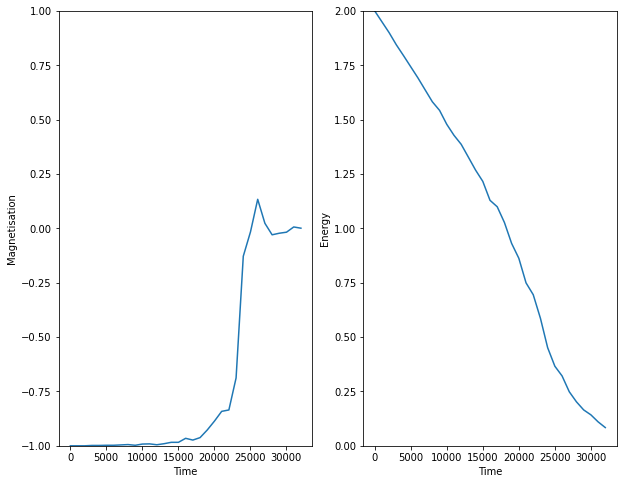

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

file = "../1.000000.csv"

meanfield_data = pd.read_csv('../1/meanfield_isingdata_CSV.csv')
data = pd.read_csv(file, sep=',', header=0, skiprows=2)
filter = slice(transience,-1,1000)

plt.figure(figsize=[10, 8])

plt.subplot(121)
plt.xlabel("Time")
plt.ylabel("Magnetisation")
plt.ylim([-1, 1])
plt.plot(data.time[filter], data.magnetisation[filter])

plt.subplot(122)
plt.xlabel("Time")
plt.ylabel("Energy")
plt.ylim([0, 2])
plt.plot(data.time[filter], data.energy[filter])

plt.show()

# data.head()

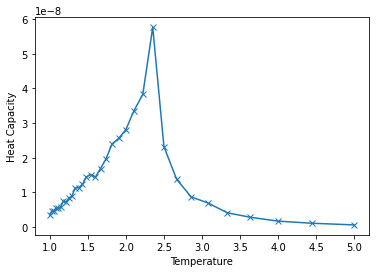

In [7]:
heat_capacity = []
temperature = []

for beta in data['beta'].unique():
    sample_filter = data['beta'] == beta
    sample_data = data[sample_filter]

    T = 1/beta
    c = 1/(N*T**2) * np.var(sample_data['energy'])
    temperature.append(T)
    heat_capacity.append(c)

plt.figure()
plt.xlabel("Temperature")
plt.ylabel("Heat Capacity")
plt.plot(temperature, heat_capacity, '-x')
plt.show()

<ipython-input-8-c9a9e2db0f6a>:16: RuntimeWarning: divide by zero encountered in true_divide
  np.power(np.sinh(T_C/T * np.log(2.414)),4)


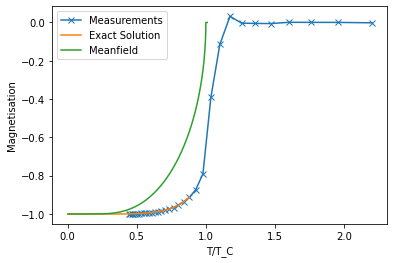

In [8]:
temperature = []
magnetisation = []

for beta in data['beta'].unique():
    sample_filter = data['beta'] == beta
    sample_data = data[sample_filter]

    T = 1/beta
    m = np.mean(sample_data['magnetisation'])
    temperature.append(T/T_C)
    magnetisation.append(m)

T = np.linspace(0, 2, 25)
m = - np.power(
    1 - 1/(
        np.power(np.sinh(T_C/T * np.log(2.414)),4)
    ),
    1/8
)

plt.figure()

plt.xlabel("Temperature")
plt.ylabel("Magnetisation")
plt.plot(temperature, magnetisation, '-x', label="Measurements")
plt.plot(T/T_C, m, label="Exact Solution")

plt.xlabel("T/T_C")
plt.ylabel("Magnetisation")
plt.plot(meanfield_data['T/T_C'], -meanfield_data['m'], label="Mean Field")

plt.legend()
plt.show()